### <h1 align="center" id="title">The IGM notebook tutorial </h1>

This tutorial aims to guide you modelling the great Aletsch Glacier, Switzerland, in a very simple set-up with the Instructed Glacier Model (IGM).

Let us firt have a look at input files

In [1]:
ls

clean.sh*    igm-run-simple.py*  mb_simple_param.txt*  README.md*
geology.nc*  igm-run-sinus.py*   notebook.ipynb*


The goal here is to take top ice surface topography and (zero) ice thickness dedined in geology.nc, and force IGM with mass balance parameters defined in mb_simple_param.txt:

In [2]:
cat mb_simple_param.txt

time  gradabl  gradacc  ela     accmax
1000    0.009    0.005    2400     2.0
1125    0.009    0.005    2400     2.0
1125.1  0.009    0.005    3315     2.0
1250    0.009    0.005    3315     2.0


First, we link the path where the code is stored, import tensorflow and the class igm, and create an igm object.

In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

sys.argv = ['']  # this is absolutly necessary in Jupyter notebook
sys.path.append('../../src/') # this simply add the path to igm

from igm import igm 
igm=igm() # create a class object igm

Next, we overide the default configuration parameters, initialize the class, and check at the parameters

In [5]:
igm.config.tstart            = 1000  # we start at time t=1000
igm.config.tend              = 1250  # we end at time   t=1250
igm.config.tsave             = 5     # we save result each 5 years
igm.config.init_strflowctrl  = 90    # we fix the ice flow strenght control to 90 (i.e. A=78, c=12)
igm.config.model_lib_path    ='../../model-lib/f12_cfsflow_GJ_21_a' # we provide the path for th ice flow emultor
igm.config.type_mass_balance = 'simple' # we use the 'simple' ELA-parametrized SMB model
igm.config.mb_simple_file    = 'mb_simple_param.txt' # this is the file where are defined the SMB params.
igm.config.usegpu            = False # we do not use the GPU for the first run
igm.config.plot_live         = False # we do not plot the result life, but vizualize a posteriori
igm.config.plot_result       = False # we do not plot the result life, but vizualize a posteriori

igm.initialize()

+++++++++++++++++++ START IGM ++++++++++++++++++++++++++++++++++++++++++
PARAMETERS ARE ...... 
                   working_dir : 
                  geology_file : geology.nc
                        tstart : 1000
                          tend : 1250
                restartingfile : 
                     verbosity : 0
                         tsave : 5
                   plot_result : False
                     plot_live : False
                        usegpu : False
                          stop : False
              init_strflowctrl : 90
                      optimize : False
                   update_topg : False
              clim_update_freq : 1
                  type_climate : 
        iceflow_model_lib_path : /home/jouvetg/IGM/model-lib/f12_cfsflow
          multiple_window_size : 0
              force_max_velbar : 0
                  vars_to_save : ['topg', 'usurf', 'thk', 'smb', 'velbar_mag', 'velsurf_mag']
                       varplot : velbar_mag
                   varplot

Now we run the classical IGM time evolution workflow (the whole thing can be replaced by gm.run())


In [6]:
# runing igm.run() is equivalent to the following comand list

with tf.device(igm.device_name):
    igm.load_ncdf_data(igm.config.geology_file)
    igm.initialize_fields()               
    igm.initialize_iceflow()
    igm.update_iceflow()                    
    igm.update_ncdf_ex()
    igm.print_info()
    while igm.t < igm.config.tend:                       
        igm.update_smb()
        igm.update_iceflow()
        igm.update_t_dt() 
        igm.update_thk()       
        igm.update_ncdf_ex()
        igm.update_plot()
        igm.print_info()

IGM 21:25:02 : Iterations =      0  |  Time =     1000  |  DT =   10.00  |  Ice Volume (km^3) =       0.00 
IGM 21:25:02 : Iterations =      1  |  Time =     1005  |  DT =   10.00  |  Ice Volume (km^3) =       0.65 
IGM 21:25:02 : Iterations =      3  |  Time =     1010  |  DT =    1.87  |  Ice Volume (km^3) =       1.30 
IGM 21:25:03 : Iterations =      8  |  Time =     1015  |  DT =    0.76  |  Ice Volume (km^3) =       1.95 
IGM 21:25:03 : Iterations =     18  |  Time =     1020  |  DT =    0.44  |  Ice Volume (km^3) =       2.60 
IGM 21:25:04 : Iterations =     31  |  Time =     1025  |  DT =    0.33  |  Ice Volume (km^3) =       3.26 
IGM 21:25:05 : Iterations =     48  |  Time =     1030  |  DT =    0.29  |  Ice Volume (km^3) =       3.92 
IGM 21:25:06 : Iterations =     74  |  Time =     1035  |  DT =    0.11  |  Ice Volume (km^3) =       4.57 
IGM 21:25:08 : Iterations =    123  |  Time =     1040  |  DT =    0.11  |  Ice Volume (km^3) =       5.23 
IGM 21:25:10 : Iterations = 

We have now modelled 250 years of evolution of the Great Aletsch Glacier! Now we can vizualize the results in form of an animation.

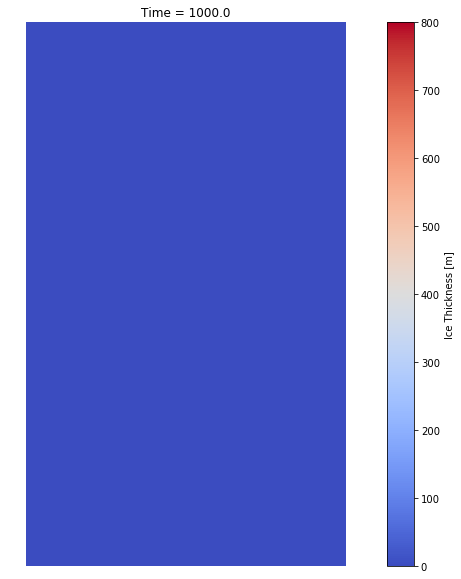

In [7]:
from IPython.display import HTML, display
import xarray as xr 
from matplotlib import pyplot as plt, animation

# open the thickness variable from the netcdf file
var = xr.open_dataset('ex.nc',engine='netcdf4').thk

fig, ax = plt.subplots(figsize=(8,10))

# Plot the initial frame. 
cax = var[0,:,:].plot(add_colorbar=True,cmap='coolwarm',vmin=0, vmax=800,cbar_kwargs={'extend':'neither'})
ax.axis("off") ; ax.axis("equal")

def animate(i):
    cax.set_array(var[i,:,:].values.flatten())
    ax.set_title("Time = " + str(var.coords['time'].values[i])[:13])

ani = animation.FuncAnimation( fig, animate, frames=var.shape[0], interval=100 ) # interval in ms between frames

HTML(ani.to_jshtml())

# optionally the animation can be saved in avi
# ani.save('animation.mp4')

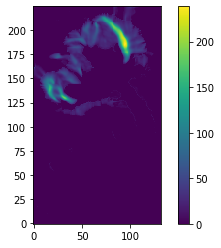

In [8]:
plt.imshow(igm.thk,origin='lower') ; plt.colorbar()

Now, we custumize the mass balance function with an oscillating ELA, and run IGM again.

In [ ]:
from igm import igm
import math

class igm(igm):

    def update_smb_sinus(self):
        """
            mass balance 'sinus'
        """

        ela     = 2800 + 500*math.sin((self.t/50)*math.pi)
        gradabl = 0.009
        gradacc = 0.005
        maxacc  = 2.0

        smb = self.usurf - ela
        smb *= tf.where(tf.less(smb, 0), gradabl, gradacc)
        smb = tf.clip_by_value(smb, -100, maxacc)
        smb = tf.where(self.icemask>0.5, smb, -10 )

        self.smb.assign( smb )

igm = igm()

igm.config.tstart            = 0
igm.config.tend              = 500
igm.config.tsave             = 2
igm.config.cfl               = 0.5
igm.config.init_strflowctrl  = 90
igm.config.model_lib_path    = '../../model-lib/f12_cfsflow_100'
igm.config.type_mass_balance = 'sinus'
igm.config.usegpu            = True

igm.run()